# 로지스틱 회귀 - 이항분류

## 로지스틱 회귀 분석 수행

### 1) 패키지 준비하기

In [4]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from tensorflow.keras.models import Sequential # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense      # 모델 객체에 학습층을 쌓기 위한 클래스
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### 2) 데이터셋 준비
- 방사선학 석사과정 대학원생을 모집하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라
- 단, 독립 변수는 정규분포(normal distribution)를 따른다고 가정한다.

|변수|구분|설명|
|--|--|--|
|합격여부|범주형|1: 합격, 0: 불합격|
|필기점수|연속형|800점 만점|
|학부성적|연속형|4.0 만점|
|병원경력|범주형|1: 10년이상, 2: 5~9년, 3: 1~4년, 4: 1년 미만

In [5]:
origin = read_excel('https://data.hossam.kr/E05/gradeuate.xlsx')
origin.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### 3) 데이터 전처리
- 결측치 확인

In [6]:
origin.isna().sum()

합격여부    0
필기점수    0
학부성적    0
병원경력    0
dtype: int64

- 명목형에 대한 데이터타입 설정

In [7]:
origin['합격여부'] = origin['합격여부'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   합격여부    400 non-null    category
 1   필기점수    400 non-null    int64   
 2   학부성적    400 non-null    float64 
 3   병원경력    400 non-null    int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 10.0 KB


### 4) 탐색적 데이터 분석
- 기본통계 확인

In [8]:
origin.describe()

,필기점수,학부성적,병원경력
count,400.000000,400.000000,400.00000
mean,587.700000,3.389900,2.48500
std,115.516536,0.380567,0.94446
min,220.000000,2.260000,1.00000
25%,520.000000,3.130000,2.00000
50%,580.000000,3.395000,2.00000
75%,660.000000,3.670000,3.00000
max,800.000000,4.000000,4.00000


- 상자그림 확인

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54596 (\N{HANGUL 

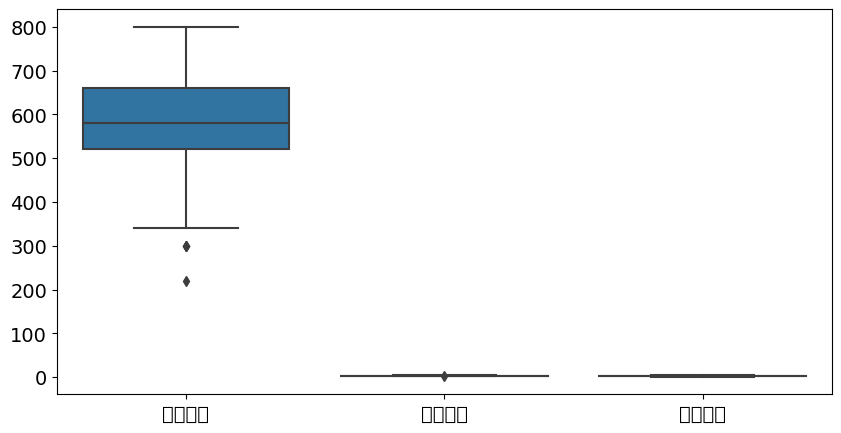

In [9]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터 단위가 크게 다르므로 표준화가 필요해 보임

### 5) 데이터셋 분할하기
- 랜덤시드 고정

In [10]:
np.random.seed(777)

- 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [11]:
x = origin[['필기점수', '학부성적','병원경력']]
y = origin[['합격여부']]
x.shape, y.shape

((400, 3), (400, 1))

- 데이터 표준화

In [12]:
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(x)
print(x_scale.shape)
x_scale

(400, 3)


array([[-1.80026271,  0.57907192,  0.54596793],
       [ 0.62666824,  0.73692942,  0.54596793],
       [ 1.84013372,  1.60514289, -1.57429586],
       ...,
       [-1.10685387, -1.99925902, -0.51416397],
       [ 0.97337266,  0.68431046, -0.51416397],
       [ 0.10661161,  1.31573861,  0.54596793]])

- 표준화 전/후 상자그림 비교

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

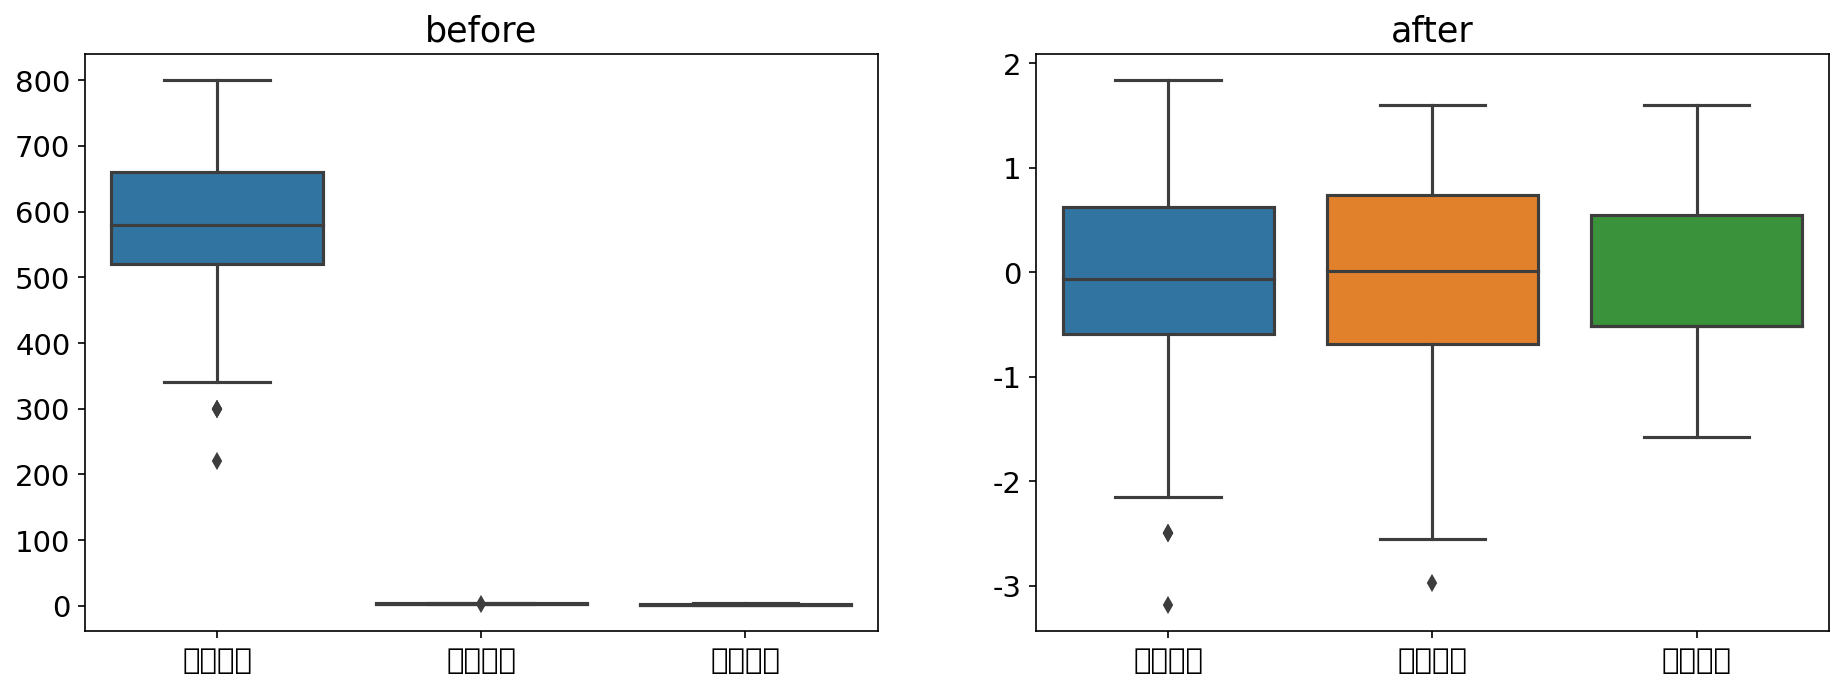

In [13]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['필기점수', '학부성적', '병원경력'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=x_scale_df, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()


- 훈련데이터와 검증데이터로 분할

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state = 777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((280, 3), (120, 3), (280, 1), (120, 1))

### 6) 모델 개발
- 모델 정의
- [relu,] sigmoid rmsporp binary_crossentropy acc

In [16]:
my_model = Sequential()
my_model.add(Dense(32, activation = 'relu', input_shape=(3, )))
my_model.add(Dense(1, activation = 'sigmoid'))
my_model.compile(optimizer='rmsprop', 
                 loss='binary_crossentropy',
                 metrics=['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기

In [17]:
result = my_model.fit(x_train,
                      y_train, 
                      epochs=500,
                      validation_data = (x_test, y_test),
                      callbacks = [EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 verbose=1),
                                   ReduceLROnPlateau(monitor='val_loss',
                                                     patience=3,
                                                     factor=0.5,
                                                     min_lr=0.0001,
                                                     verbose=1)])

Epoch 1/500
9/9 [==============================] - 0s 13ms/step - loss: 0.6546 - acc: 0.6214 - val_loss: 0.6310 - val_acc: 0.6917 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6368 - acc: 0.6500 - val_loss: 0.6158 - val_acc: 0.7000 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6265 - acc: 0.6679 - val_loss: 0.6042 - val_acc: 0.7167 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6189 - acc: 0.6821 - val_loss: 0.5952 - val_acc: 0.7167 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6133 - acc: 0.6750 - val_loss: 0.5877 - val_acc: 0.6917 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6087 - acc: 0.6679 - val_loss: 0.5813 - val_acc: 0.7000 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 3ms/step - loss: 0.6050 - acc: 0.6786 - val_loss: 0.5753 - val_acc: 0.7000 - lr: 0.0010
Epoch

### 7) 학습 결과 평가

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

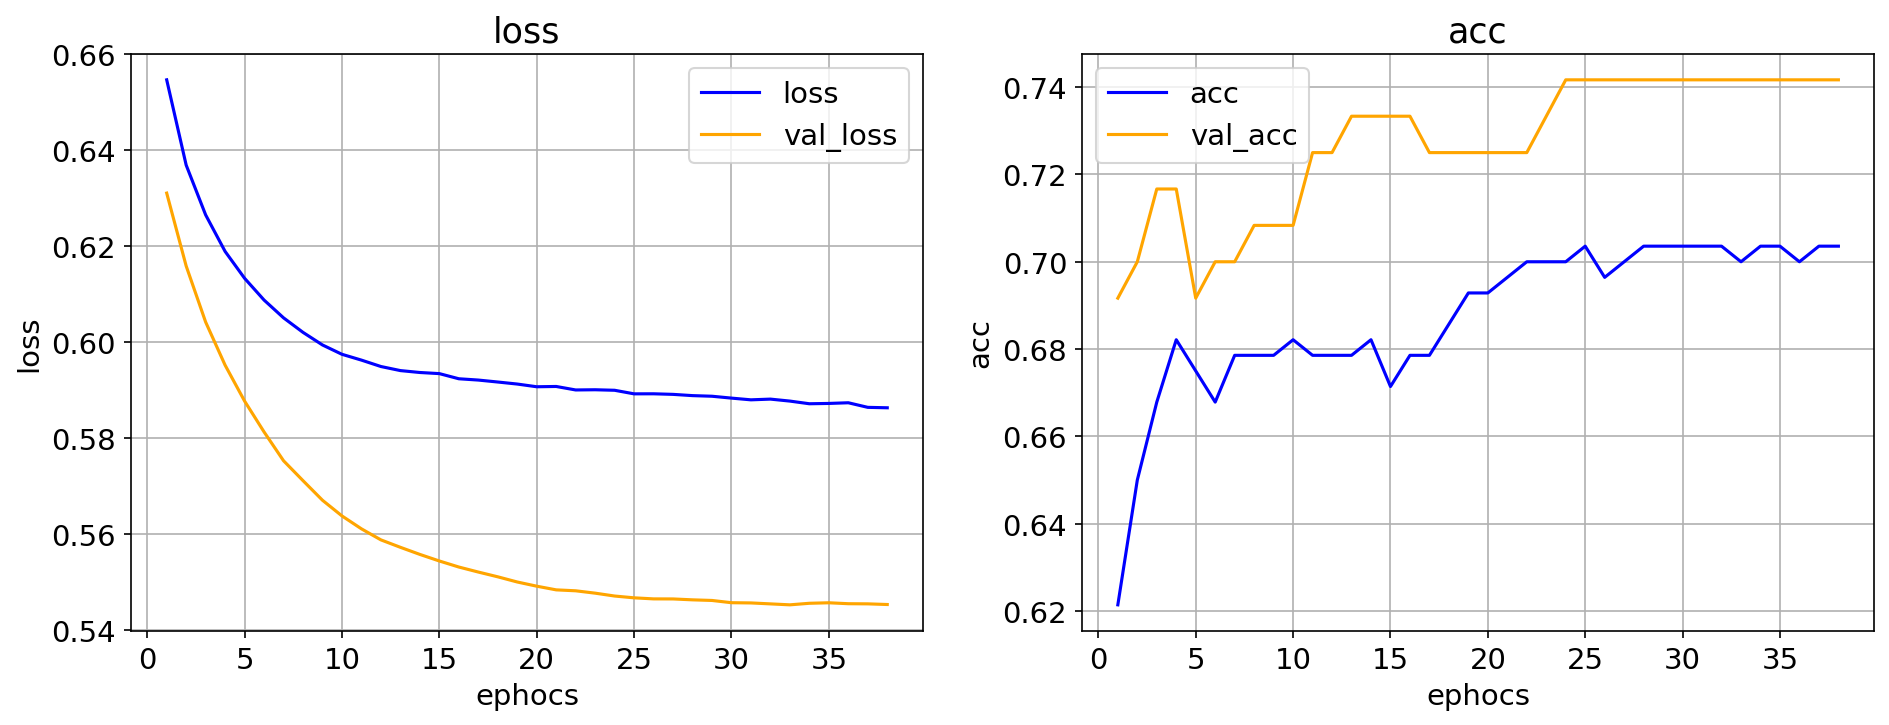

9/9 [==============================] - 0s 728us/step - loss: 0.5858 - acc: 0.7000
최종 훈련 손실룰: 0.585801, 최종 훈련 정확도: 0.700000
4/4 [==============================] - 0s 859us/step - loss: 0.5454 - acc: 0.7417
최종 검증 손실률: 0.545363, 최종 검증 정확도: 0.741667


In [18]:
helper.tf_result_plot(result)

evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실룰: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

### 8) 학습 결과 적용
- 훈련 데이터에 대한 예측 결과 산정

In [19]:
train_pred = my_model.predict(x_train)
data_count, case_count = train_pred.shape
print('%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
print(train_pred)

9/9 [==============================] - 0s 523us/step
280개의 훈련 데이터가 1개의 경우의 수를 갖는다.
[[0.39642125]
 [0.53339684]
 [0.13520591]
 [0.21914482]
 [0.15968062]
 [0.13103957]
 [0.4861693 ]
 [0.51576245]
 [0.33677882]
 [0.40094516]
 [0.32884   ]
 [0.3583506 ]
 [0.4586125 ]
 [0.29313987]
 [0.17055279]
 [0.4209932 ]
 [0.2097536 ]
 [0.4775457 ]
 [0.5635714 ]
 [0.5005306 ]
 [0.32300854]
 [0.51688313]
 [0.3308776 ]
 [0.13586631]
 [0.36374617]
 [0.33227888]
 [0.43463063]
 [0.33831292]
 [0.45675018]
 [0.47862712]
 [0.34206942]
 [0.47907928]
 [0.3469862 ]
 [0.22713865]
 [0.37694755]
 [0.2764097 ]
 [0.18169522]
 [0.08429828]
 [0.32011932]
 [0.4149415 ]
 [0.4179128 ]
 [0.13678649]
 [0.44430998]
 [0.31857997]
 [0.29160804]
 [0.4516215 ]
 [0.08770265]
 [0.2953635 ]
 [0.46066785]
 [0.14407805]
 [0.44102216]
 [0.3573014 ]
 [0.44238418]
 [0.15079245]
 [0.4664556 ]
 [0.5248494 ]
 [0.35526395]
 [0.44102216]
 [0.14678511]
 [0.3165926 ]
 [0.40212542]
 [0.42741156]
 [0.26637766]
 [0.32089898]
 [0.215888  ]
 [0.222

- 검증 데이터에 대한 예측 결과 산정

In [20]:
test_pred = my_model.predict(x_test)
data_count, case_count = train_pred.shape
print('%d개의 검증 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
print(test_pred)

4/4 [==============================] - 0s 895us/step
280개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[0.24618056]
 [0.2816202 ]
 [0.21216935]
 [0.24756543]
 [0.46216455]
 [0.19216646]
 [0.51471704]
 [0.14336987]
 [0.3355888 ]
 [0.4632692 ]
 [0.5490991 ]
 [0.283002  ]
 [0.14580873]
 [0.44567   ]
 [0.4006287 ]
 [0.34620827]
 [0.49136102]
 [0.31521136]
 [0.4084267 ]
 [0.19535346]
 [0.16673106]
 [0.33227888]
 [0.33455828]
 [0.19334112]
 [0.33294436]
 [0.44082743]
 [0.18086788]
 [0.45452285]
 [0.35360762]
 [0.42421165]
 [0.27867293]
 [0.0489634 ]
 [0.2136965 ]
 [0.32313088]
 [0.39792103]
 [0.34651732]
 [0.21439321]
 [0.33860737]
 [0.24450167]
 [0.2916393 ]
 [0.23547931]
 [0.34945247]
 [0.43843216]
 [0.47110096]
 [0.46895933]
 [0.15393423]
 [0.17494164]
 [0.16631043]
 [0.1011732 ]
 [0.4805308 ]
 [0.3043826 ]
 [0.29980528]
 [0.10560285]
 [0.17607069]
 [0.52605915]
 [0.17958787]
 [0.5165324 ]
 [0.4133506 ]
 [0.19680698]
 [0.52317107]
 [0.49315152]
 [0.45803574]
 [0.19055717]
 [0.20771235]
 [0.49065036]
 [0.327

- 결과 데이터셋 구성

In [21]:
kdf = DataFrame({
    '결과값': y_train['합격여부'].values,
    '예측값': np.round(train_pred.flatten()),
    '합격확률(%)': np.round(train_pred.flatten() * 100, 1)
})
kdf

,결과값,예측값,합격확률(%)
0,1,0.0,39.599998
1,1,1.0,53.299999
2,1,0.0,13.500000
3,0,0.0,21.900000
4,0,0.0,16.000000
...,...,...,...
275,0,0.0,4.400000
276,0,0.0,46.099998
277,0,0.0,15.100000
278,1,0.0,46.099998


- 혼돈행렬
    - 각 항목의 의미:
        |구분|설명|
        |--|--|
        |TN(True Negative, Negative Negative)|실제는 Negative인데, Negative로 예측함.|
        |FP(False Positive, Negative Positive)|실제는 Negative인데, Positive로 예측함. (Type1 Error)|
        |FN(False Negative, Positive Negative)|실제는 Positive인데, Negative로 예측함. (Type2 Error)|
        |TP(True Positive, Positive Positive)|실제는 Positive인데, Positive로 예측함.|

In [22]:
cm = confusion_matrix(kdf['결과값'], kdf['예측값'])
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
cmdf1 = DataFrame([[tn, tp], [fn, fp]], 
                  index=['True', 'False'], 
                  columns=['Negative', 'Positive'])
cmdf1

182 7 77 14


,Negative,Positive
True,182,14
False,77,7


In [23]:
cm2 = confusion_matrix(kdf['결과값'], kdf['예측값'])
cmdf2 = DataFrame(cm2, 
                  index=['실제(False)', '실제(True)'], 
                  columns=['예측(Negative)', '예측(Positive)'])

/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dayoonz/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing fro

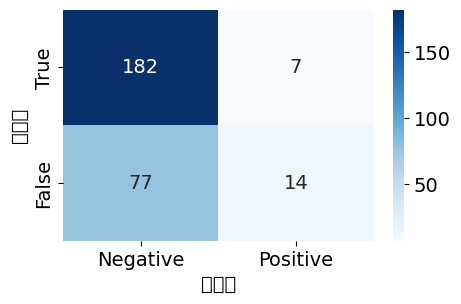

In [24]:
plt.figure(figsize=(5, 3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sb.heatmap(cm,
           annot = True,
           fmt = 'd',
           cmap = 'Blues')
plt.xticks([0.5,1.5], ['Negative', 'Positive'])
plt.yticks([0.5,1.5], ['True', 'False'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

- 평가지표

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

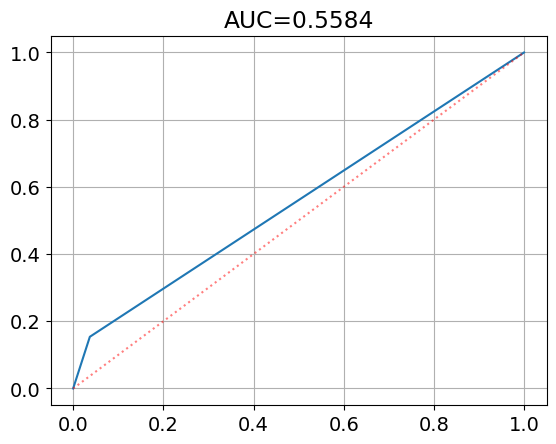

In [25]:
ras = roc_auc_score(kdf['결과값'], kdf['예측값'])
# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(kdf['결과값'], kdf['예측값'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1],
            y=[0,1],
            color='red',
            linestyle=':',
            alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [26]:
# 정확도
acc = accuracy_score(kdf['결과값'], kdf['예측값'])

# 정밀도
pre = precision_score(kdf['결과값'], kdf['예측값'])

# 재현율
recall = recall_score(kdf['결과값'], kdf['예측값'])

# F1 score
f1 = f1_score(kdf['결과값'], kdf['예측값'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'정확도(Accuracy)': [acc],
                       '정밀도(Precision)': [pre],
                       '재현율(Recall, TPR)': [recall],
                       '위양성율(Fallout, FPR)': [fallout],
                       '특이성(Specificity, TNR)': [spe],
                       'RAS': [ras],
                       'f1_score': [f1]})

result_df

,정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.7,0.666667,0.153846,0.037037,0.962963,0.558405,0.25


- 분류 보고서
    - precision : 정밀도 (분류기가 참으로 분류한 항목 중에서 실제 데이터가 참인 비율)
    - recall : 재현율 (실제 참 중에서 분류기가 참으로 분류한 비율)
    - f1-score : 2(Recall Precision) / (Recall + Precision)
        - Precision과 Recall의 조화평균
        - 주로 분류 클래스 간 데이터가 심각한 불균형을 이루는 경우에 사용
        - 정확도의 경우, 클래스가 데이터 분류가 균일하지 못하면 머신의 성능을 제대로 나타내줄 수 없기 때문에 F1을 사용한다.
    - support : 전체 데이터 수

In [27]:
report = classification_report(kdf['결과값'], kdf['예측값'])
print(report)

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       189
           1       0.67      0.15      0.25        91

    accuracy                           0.70       280
   macro avg       0.68      0.56      0.53       280
weighted avg       0.69      0.70      0.63       280

